# Here goes the first implementation of variational Quantum Monte Carlo ground state solver

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Latex

## Represent the Restricted Boltzman machine foolishly

In [2]:
class RBM:
    "Super simple implementation of an RBM with complex parameters."
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.init()
        
    def init(self):
        "Reinitializes the complex parameters at random imaginary values."
        b = np.random.randn(self.n_visible) + 1j*np.random.randn(self.n_visible) # visible bias
        c = np.random.randn(self.n_hidden) + 1j*np.random.random(self.n_hidden)  # hidden bias
        W = (np.random.randn(self.n_hidden, self.n_visible) + 
             1j*np.random.randn(self.n_hidden, self.n_visible))                  # weights
        self.params = np.concatenate((b, c, W.ravel())) / 10
        
    @property
    def b(self): return self.params[:self.n_visible]
    
    @property
    def c(self): return self.params[self.n_visible:self.n_visible+self.n_hidden]
    
    @property
    def W(self): return np.reshape(self.params[self.n_visible+self.n_hidden:], 
                                (self.n_hidden, self.n_visible))

    def p(self, v):
        "Probability amplitude of a visible state `v`. We don't need it for Monte Carlo."
        return np.exp(np.conj(self.b) @ v)*np.prod(np.cosh(self.c + self.W @ v))*(2**self.n_hidden)
    
    def p_ratio(self, v1, v2):
        "Probability ratio between state `v2` and reference `v1`"
        f1 = np.cosh(self.c + self.W @ v1)
        f2 = np.cosh(self.c + self.W @ v2)
        log_diff = np.conj(self.b) @ (v2-v1) + sum(np.log(f2/f1)) # log of ratio for numerical stability
        return np.exp(log_diff)
    
    def p_ratios(self, v1, v2):
        "Probability ratio between list of states `v2` and reference state `v1`."
        return [self.p_ratio(v1, v) for v in v2] 

## Define the system

$H = \sum _i^{L-1} J\sigma_i^z\sigma_{i+1}^z + (g+w_i)\sigma _i^x + h\sigma_i^z$

In [4]:
np.random.seed(7)
n = 6
J = -2
h = 0.1
g = -1
dw = 0.1
#gi = np.array([g for i in range(n)])
gi = np.array(g + np.random.random(n) * 2*dw - dw) # introduce some randomness
nvis, nhid = n, 2*n
psi = RBM(nvis, nhid)

gi



array([-1.08473834, -0.94401624, -1.01231815, -0.95530696, -0.9044021 ,
       -0.99230083])

## Define local stuff

In [5]:
def flip(x, i):
    xflip = np.copy(x)
    xflip[i] = 1 - xflip[i]
    return xflip

def localEnergy(x, psi):
    int = (x[:-1]==x[1:])*2-1
    e_int = J * np.sum(int)
    
    # flips
    states_with_flip = [flip(x, i) for i in range(len(x))]
    e_field = np.sum(gi*psi.p_ratios(x, states_with_flip))
    
    # h field
    e_h = h * np.sum(x*2 - 1)
    return e_int + e_field + e_h



## Monte Carlo ;3


In [6]:
n_samples = 5000  # samples for training
n_flips = 1 # new configurarion
state = np.random.randint(0, 2, n) # initial random state
states, energies = [], []


for k in tqdm(range(n_samples)):
    # Sample new state
    spin_idx = np.random.randint(0, n, n_flips)
    new_state = flip(state, spin_idx)

    if np.random.random() <= np.abs(psi.p_ratio(state, new_state))**2:
        state = np.copy(new_state)   # Accept new state
    states.append(state)
    energies.append(np.real(localEnergy(state, psi)))

100%|██████████| 5000/5000 [00:01<00:00, 2693.11it/s]


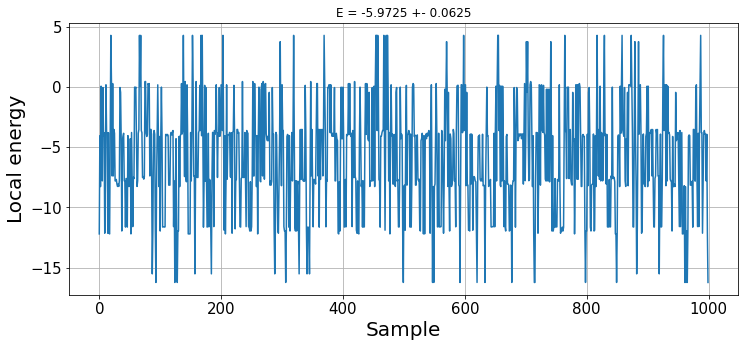

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(energies[:1000]) # Plot some
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel("Local energy", fontsize=20)
plt.xlabel("Sample", fontsize=20)
plt.title(f"E = {np.mean(energies):.4f} +- {np.std(energies)/np.sqrt(n_samples):.4f}");

### binning

-5.9669 +- 0.0669 for k=512


1.1468560072396239

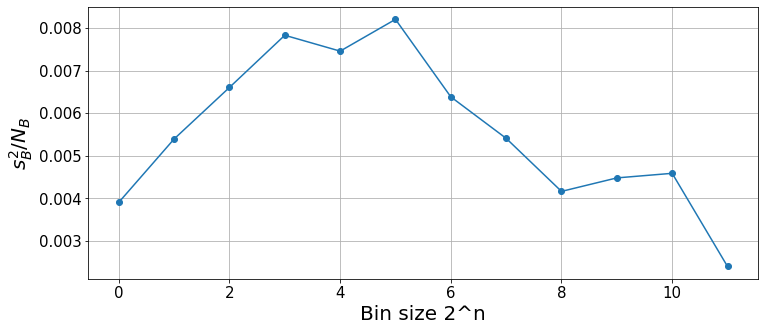

In [8]:
def bin_averages(x, bs):
    "Bins time-series `x` into `bs` chunks and takes means"
    nb = len(x)//bs
    bin_avg = [np.mean(x[b*bs:(b+1)*bs]) for b in range(nb)]
    return np.array(bin_avg)

ks = [2**k for k in range(12)]
errors, means, bin_avgs = [], [], []

for k in ks:
    bin_avg = bin_averages(energies, k)
    error = np.sqrt(np.var(bin_avg)/len(bin_avg))
    errors.append(error)
    means.append(bin_avg.mean())
    bin_avgs.append(bin_avg)
    
plt.figure(figsize=(12, 5))
plt.plot(np.log2(ks), np.array(errors)**2, 'o-')
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$s_B^2/N_B$", fontsize=20)
plt.xlabel("Bin size 2^n", fontsize=20)
print(f"{means[-3]:.4f} +- {errors[-3]:.4f} for k={ks[-3]}")
tau = (errors[-3]/errors[0])**2; tau

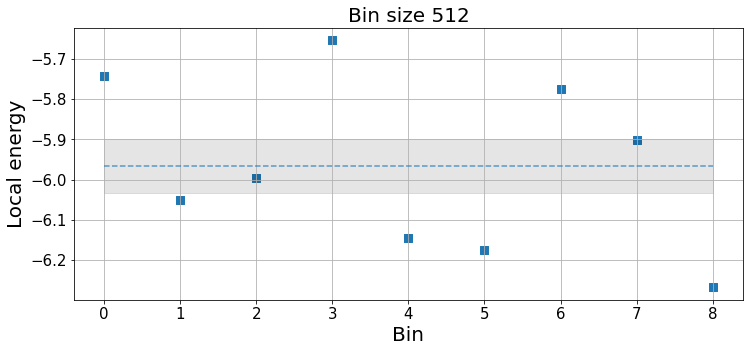

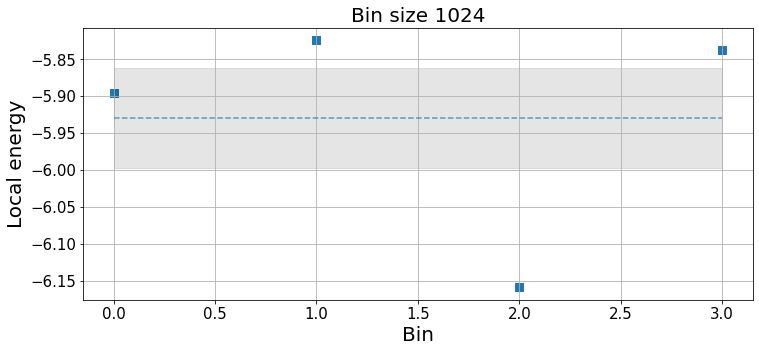

In [9]:
k_idx = -3 # Choose the bin size
bins = np.arange(len(bin_avgs[k_idx]))
plt.figure(figsize=(12, 5))
plt.scatter(bins, bin_avgs[k_idx], s=50, marker='s')
plt.hlines(means[k_idx], bins[0], bins[-1], linestyles='--', alpha=0.7)
plt.fill_between(bins, means[k_idx]-errors[k_idx], means[k_idx]+errors[k_idx], color='k', alpha=0.1)
plt.grid()
plt.tick_params(labelsize=15)
plt.title(f"Bin size {ks[k_idx]}", fontsize=20)
plt.ylabel("Local energy", fontsize=20)
plt.xlabel("Bin", fontsize=20);

k_idx = -2 # Choose the bin size
bins = np.arange(len(bin_avgs[k_idx]))
plt.figure(figsize=(12, 5))
plt.scatter(bins, bin_avgs[k_idx], s=50, marker='s')
plt.hlines(means[k_idx], bins[0], bins[-1], linestyles='--', alpha=0.7)
plt.fill_between(bins, means[k_idx]-errors[k_idx], means[k_idx]+errors[k_idx], color='k', alpha=0.1)
plt.grid()
plt.tick_params(labelsize=15)
plt.title(f"Bin size {ks[k_idx]}", fontsize=20)
plt.ylabel("Local energy", fontsize=20)
plt.xlabel("Bin", fontsize=20);

### Weights change

In [10]:
#### autocorrelation time was ~ 5 -> draw each fifth sample


def variational_derivative(x, psi):
    "Computes variational derivatives for SR"
    theta = psi.c + psi.W @ x
    # change of the first bias
    Ob = x
    # change of the second bias
    Oc = np.tanh(theta)
    # change of the weight matrices
    Ow = Oc[:, None] @ x[None, :]
    return np.concatenate((Ob, Oc, Ow.ravel()))

def covariance(x1, x2):
    "Computes the covariance between `x1` and `x2`."
    samples = x1.shape[1]
    m1 = np.mean(x1, axis=1)
    m2 = np.mean(x2, axis=1) if len(x2.shape)>1 else np.mean(x2)
    return (x1 @ x2.T)/samples - m1[:,None] @ m2[None,:]


def sample_block(psi, bs, x0=None, n_flips=1):
    "Sample `bs` states according to `psi`."
    state = np.random.randint(0, 2, psi.n_visible) if x0 is None else x0
    states = []
    for _ in range(bs):
        spin_idx = np.random.randint(0, psi.n_visible, n_flips)
        new_state = flip(state, spin_idx)
        if np.random.random() <= np.abs(psi.p_ratio(state, new_state))**2:
            state = np.copy(new_state)   # Accept new state   
        states.append(state)
    return states

In [11]:
learning_iterations = 200
lr = 1e-2
n_blocks = 180
thermalise = int(0.1*n_blocks) # we leave some for thermalization
Nb = n_blocks - thermalise
bs = 2**4 # number of autocorrelation blocks
n_flips = 1 # number of flips at the same time
energies = [] 

for it in tqdm(range(learning_iterations)):
    EL, O = np.zeros(Nb, dtype=complex), np.zeros((len(psi.params), Nb), dtype=complex)
    states = sample_block(psi, thermalise*bs, n_flips=n_flips)
    # take the last state
    state = states[-1]
    for k in range(Nb):
        batch = sample_block(psi, bs, x0=state, n_flips=n_flips)
        states += batch
        state = batch[-1]
        EL[k] = localEnergy(state, psi)
        O[:, k] = variational_derivative(state, psi)
    
    energies.append(EL.mean())
    F = covariance(O.conj(), EL[None,:])   # Gradient
    S = covariance(O.conj(), O)            # Fisher info
    Sinv = np.linalg.pinv(S, rcond=1e-7)   # (pseudo)Inversion
    d_params = lr*Sinv @ F
    psi.params -= d_params.squeeze()

100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


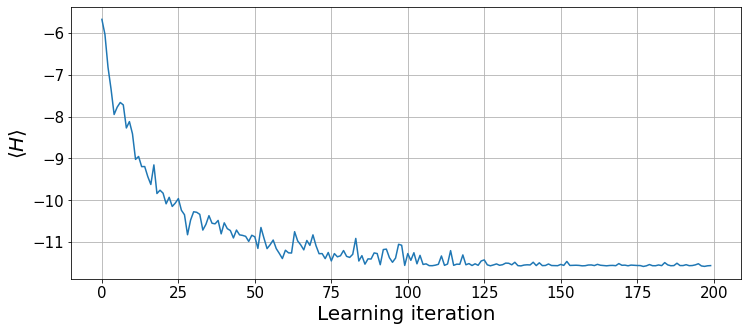

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(energies))
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$\langle H\rangle$", fontsize=20)
plt.xlabel("Learning iteration", fontsize=20);

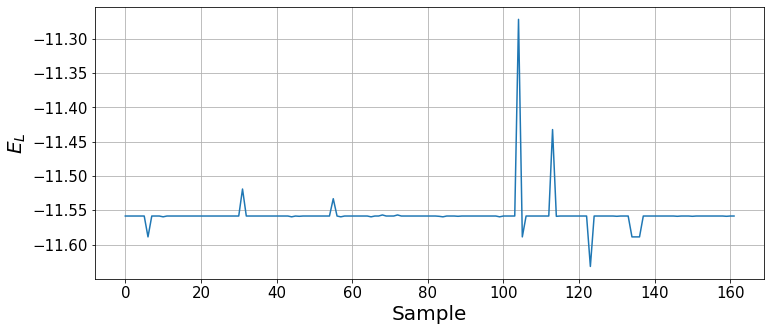

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(EL))

plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$E_L$", fontsize=20)
plt.xlabel("Sample", fontsize=20);

In [14]:
bins = 100
energy = np.mean(np.real(energies[-bins:]))
statistical_error = np.std(energies[-bins:])/np.sqrt(bins)
print(f"The obtained energy is {energy:.4f}+-{statistical_error:.4f}")

The obtained energy is -11.5220+-0.0075


In [15]:
print(f"The last state is {state}")

The last state is [0 0 0 0 0 0]


# ED

In [21]:
from common.__common__ import *
def flipOne(v, i):
    v2 = np.copy(v)
    v2[i] = 1 - v2[i]
    return v2

In [22]:
N = 2**n
H = np.zeros((N,N))
print(n, N)
for i in range(N):
    vec = numberToBase(i, 2, n)
    for j in np.arange(0,len(vec)):
        # interaction
        s_j = -1 if vec[j] == 0. else 1.
        if j < n-1:
            s_jp1 = (-1. if vec[j+1] == 0. else 1.)
            H[i,i] += J * s_j * s_jp1
        # magnetic field perp
        H[i,i] += h * s_j
        
        # transverse field
        flipped = flipOne(vec, j)
        newIdx = baseToNumber(flipped, 2)
        H[newIdx, i] += gi[j]
pd.DataFrame(H)

6 64


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-10.600000,-0.992301,-0.904402,0.000000,-0.955307,0.000000,0.000000,0.000000,-1.012318,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.992301,-6.400000,0.000000,-0.904402,0.000000,-0.955307,0.000000,0.000000,0.000000,-1.012318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.904402,0.000000,-2.400000,-0.992301,0.000000,0.000000,-0.955307,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.904402,-0.992301,-6.200000,0.000000,0.000000,0.000000,-0.955307,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.955307,0.000000,0.000000,0.000000,-2.400000,-0.992301,-0.904402,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.904402,-0.992301,-1.600000,0.000000,0.000000,0.000000,-0.955307
60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.955307,0.000000,0.000000,0.000000,-5.800000,-0.992301,-0.904402,0.000000
61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.955307,0.000000,0.000000,-0.992301,-1.600000,0.000000,-0.904402
62,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.012318,0.000000,0.000000,0.000000,-0.955307,0.000000,-0.904402,0.000000,-5.600000,-0.992301


In [23]:
e_vals, e_vecs = np.linalg.eigh(H)
e_vals, e_vecs[0]

(array([-11.56674658, -10.45528127,  -8.41721424,  -8.37495631,
         -7.35320822,  -7.3059288 ,  -6.4413859 ,  -6.4118817 ,
         -5.74482409,  -5.71356576,  -5.18471061,  -5.11349049,
         -4.82263243,  -4.52832288,  -3.97103926,  -3.55602008,
         -3.32332511,  -2.90399848,  -2.88865175,  -2.77356972,
         -2.59854342,  -2.29906664,  -2.18788358,  -1.82966977,
         -1.77007441,  -1.32200953,  -1.16294229,  -1.03054382,
         -0.80538259,  -0.41514518,  -0.08204279,  -0.04049398,
         -0.02829301,   0.1808361 ,   0.59138298,   0.63231814,
          1.07882484,   1.12366575,   1.5085283 ,   1.54861841,
          2.00044514,   2.04481995,   2.54439504,   2.57769364,
          2.72866349,   2.76046723,   3.05080418,   3.09202119,
          3.74839309,   3.7908223 ,   4.65098908,   4.69222242,
          5.14543391,   5.31153519,   5.62741867,   5.81168681,
          6.2268197 ,   6.57281527,   7.24789534,   7.38366597,
          8.28675072,   8.44429363,  10.

In [24]:
relative_error = np.abs((energy-e_vals[0])/e_vals[0])
print(f"The exact ground state energy is {e_vals[0]:.4f}")
print(f"Relative error between variational energy {energy:.4f} and exact solution {e_vals[0]:.4f}: {relative_error*100:.4f}%")

The exact ground state energy is -11.5667
Relative error between variational energy -11.5220 and exact solution -11.5667: 0.3871%


In [25]:
a = printState(n, e_vecs[0], threshold = 1e-2)
display(Latex(a))

<IPython.core.display.Latex object>